# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

# Import libraries 

In [1]:
import torch
import imageio
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

## Device and random seed

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")
random_seed = 1234
torch.manual_seed(random_seed)

Device used: cuda


## Load Data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/heat_transfer_finn.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields_G = ['G']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
df_train, df_test = train_test_split(df_T, test_size = split_ratio, random_state=random_seed)

# Convert into numpy arrays
X_train, Y_train = (df_train[fields_T].to_numpy(), df_train[fields_G].to_numpy())
X_test, Y_test = (df_test[fields_T].to_numpy(), df_test[fields_G].to_numpy())

# Print shapes
print("X_test information:")
print("the size of X_test is", X_test.size)
print("the shape of X_test is", X_test.shape)

print("X_train information:")
print("the size of X_train is", X_train.size)
print("the shape of X_train is", X_train.shape)

print("Y_train information:")
print("the size of Y_train is", Y_train.size)
print("the shape of Y_train is", Y_train.shape)

print("Y_test information:")
print("the size of Y_test is", Y_test.size)
print("the shape of Y_test is", Y_test.shape)

X_test information:
the size of X_test is 900
the shape of X_test is (100, 9)
X_train information:
the size of X_train is 3600
the shape of X_train is (400, 9)
Y_train information:
the size of Y_train is 400
the shape of Y_train is (400, 1)
Y_test information:
the size of Y_test is 100
the shape of Y_test is (100, 1)


### Normalization $\overline{\theta[i,j]} = 2\frac{\theta[i,j] \min(\theta[:,j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$ functions:

In [4]:
def normalize_ij(xi, xmax, xmin):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array):
    """
    Normalize an array by columns computing the max and min of each column.
    
    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    min_X_cols = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_X_cols = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    normalized_X_array = np.zeros_like(X_array)
    
    # Fill the copy vector
    for col in range(num_col_X): 
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], max_X_cols[col] , min_X_cols[col])
        
    return normalized_X_array, min_X_cols, max_X_cols

### Define a NN with customizable architecture

In [5]:
def create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers):
    """
    Function to create a sequentual NN model.

    Parameters:
       dim_input (int):                      Input dimension (number of features).
       dim_output (int):                     Output dimension (number of features).
       num_hidden_layers(int):               Number of hidden layers.
       nun_nuerons_hidden_layers (int):      Number of hidden layers.   
   """      
    # create an empty sequentail model
    Net = torch.nn.Sequential()

    # Add first layer 
    Net.add_module("input_layer", torch.nn.Linear(dim_input, nun_nuerons_hidden_layers))
     
    # Add hidden layers
    for nhidden_layer in range(num_hidden_layers):
        Net.add_module(
            "hidden_layer_num_{}".format(nhidden_layer + 1),
            torch.nn.Linear(nun_nuerons_hidden_layers, nun_nuerons_hidden_layers)
        )
        Net.add_module("hidden_activation_num_{}".format(nhidden_layer + 1 ), torch.nn.LeakyReLU())

    # Add output layer
    Net.add_module("output_layer", torch.nn.Linear(nun_nuerons_hidden_layers, dim_output))
        
    return Net

## Train and test function: ` train_test_model `

In [6]:
def train_test_model(
    num_data_training, 
    nun_nuerons_hidden_layers, num_hidden_layers,
    num_epochs,
    X_train, Y_train, X_test, Y_test,
    device,
    generate_gif = False,
    normalize_bool = True):
    """
    Function to build, test and train the model.

    Parameters:
       num_data_trainging (int):        Number of samples.
       nun_nuerons_hidden_layers (int): Number of neurons for each hidden layer.
       num_hidden_layers (int):         Number of hidden layers.
       num_epochs (int):                Number of epochs to train the model.   
       X_train (ndarray):               Numpy array contaning the traning set inputs.   
       Y_train (ndarray):               Numpy array contaning the training set outputs.   
       X_test (ndarray):                Numpy array contaning the testing set inputs.   
       Y_test (ndarray):                Numpy array contaning the testing set outputs. 
       device (string):                 'cpu' or 'cuda'
       generate_gif (bool):             Boolean to generate a training .gif.
       nromalize_bool (bool):           Boolean to normalize the input data.

   """        
    
    ###############################################
    ############# TRAINING STAGE ##################
    ###############################################
    
    # Pick the first num data trainig samples for X and Y
    X_train_reduced = X_train[:num_data_training,1:] # Skip the first value since no adds any extra info
    num_col_Xr = X_train_reduced.shape[1]
    Y_train_reduced = Y_train[:num_data_training]
    num_col_Y = Y_train_reduced.shape[1]
    
    # Normalize X_train
    if normalize_bool:
        normalized_X_reduced_train, _, _ = normalize(X_train_reduced)
    else:
        normalized_X_reduced_train = X_train_reduced

    
    # Transofrm from numpy to torch into torch x_train and y_train 
    x_to_plot = normalized_X_reduced_train.reshape(-1,num_col_Xr)             
    x_train = torch.from_numpy(x_to_plot).float().to(device)
    y_train = torch.from_numpy(Y_train_reduced.reshape(-1,num_col_Y)).float().to(device)
    
    # Define model architecture and copy the model to device
    dim_input = x_train.shape[1]
    dim_output = num_col_Y
    Net = create_NN(dim_input, dim_output, nun_nuerons_hidden_layers, num_hidden_layers)
    Net.to(device)
    
    # Watch x,y variables into torch
    x_train = Variable(x_train)
    y_train = Variable(y_train)
    
    # Training parameters
    loss_function = torch.nn.MSELoss()
    LearningRate = 1e-4
    adam_only_loss = np.zeros(num_epochs)

    # Define optimizer
    optimizer_adam = torch.optim.Adam(Net.parameters(), lr = LearningRate)

    # Image
    if generate_gif:
        fig, ax = plt.subplots(figsize=(15,10))
        image_list = []

    # Initialize variable to measure time
    start_time = time.time()
    
    # Train the model
    for epoch in range(num_epochs):
        y_pred = Net(x_train)
        loss = loss_function(y_pred, y_train)  # Notice the order: NN Pred first and then actual value
        optimizer_adam.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer_adam.step()
        adam_only_loss[epoch] = loss.to('cpu').detach().numpy()
        
        # Print gif for a 50 epochs step
        if epoch%50==0 and generate_gif:
        
            # Temperature index to plot 
            temp_to_plot_idx = 0 #[ 0 => T1, 1 => T2]
            # Compute testing values to plot
            X_test_reduced = X_test[:,1:] # Skip the first temperature
            if normalize_bool:
                normalized_X_test, _, _ = normalize(X_test_reduced)
            else:
                normalized_X_test = X_test_reduced

            x_test_to_plot = normalized_X_test[:,temp_to_plot_idx].reshape(-1,1)
            y_test = (Y_test.reshape(-1,num_col_Y))

            
            # Compute training values to plot 
            x_train_cpu = x_train.to('cpu').detach().numpy()
            x_train_to_plot = x_train_cpu[:,temp_to_plot_idx].reshape(-1,1)
            y_train_to_plot = y_train.to('cpu').detach().numpy()
            
            y_pred_to_plot = y_pred.to('cpu').detach().numpy()
            
            # Plot
            plt.cla()
            ax.scatter(x_test_to_plot, y_test, color = "red", label="Testing Data")
            ax.scatter(x_train_to_plot, y_train_to_plot, color = "blue", label="Training Data")
            ax.plot(x_train_to_plot[:,0], y_pred_to_plot, 'k--', lw=2,  label="NN Apprximated")
            
            # Labels
            if normalize_bool:
                ax.set_xlabel(r'$norm\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
            else:
                ax.set_xlabel(r'$\theta_{}$'.format(temp_to_plot_idx + 2), fontsize=32)
                
            ax.set_ylabel('$G$', fontsize=32)
            ax.set_xlim(min(x_test_to_plot), max(x_test_to_plot))
            ax.set_ylim(0, 1)

            
            ax.text(min(x_test_to_plot), 1 , 'Adam Optimizer: epoch = %d,' %epoch, fontdict={'size': 22, 'color':  'black'})
            ax.text(min(x_test_to_plot) + (max(x_test_to_plot) - min(x_test_to_plot))/2, 1, 'Loss = %.6f' % loss,
                    fontdict={'size': 22, 'color':  'black'})
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.legend()

            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            image_list.append(image)

    
    elapsed_time = time.time() - start_time
    
    if generate_gif:
        name = './part1_outputs/gifs/Adam_ndata_{}_nhlayers_{}_nromalized_{}.gif'.format(num_data_training, num_hidden_layers, normalize_bool)
        imageio.mimsave(name, image_list, fps=5)
    
    print(f"With num_data_training: {num_data_training} the final loss is: {loss:.5e}")

    
    ###############################################
    ############# TESTING STAGE ##################
    ###############################################
    # Normalize X_test
    X_test_reduced = X_test[:,1:] # Skip the first temperature
    if normalize_bool:
        normalized_X_test, _, _ = normalize(X_test_reduced)
    else:
        normalized_X_test = X_test_reduced
    
    # Convert into torch x_test and y_test 
    x_test = torch.from_numpy(normalized_X_test.reshape(-1,num_col_Xr)).float().to(device)
    y_test = torch.from_numpy(Y_test.reshape(-1,num_col_Y)).float().to(device)

    # Compute y predict
    y_nn = Net(x_test)
    error_test = loss_function(y_nn, y_test).to('cpu').detach().numpy()  # Notice the order: NN Pred first and then actual value

    return adam_only_loss, error_test, elapsed_time, Net

### Plot T(x) for different G values

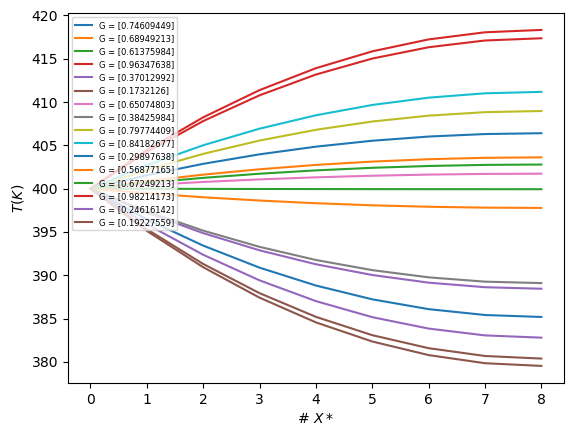

In [7]:
num_sample_plots = 15
samples_ploted = []

plt.cla()

while len(samples_ploted) <= num_sample_plots:
    sample_picked = np.random.randint(0, X_train.shape[0])
    label =  'G = {}'.format(Y_train[sample_picked])
    if sample_picked not in samples_ploted:
        plt.plot(X_train[sample_picked,:],label=label)
        samples_ploted.append(sample_picked)
  
plt.xlabel('# $X*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 6})
plt.savefig('part1_outputs/figures/TvsX.png')
plt.show()

   ### $G$ vs $[T_1, T_2,... T_9]$

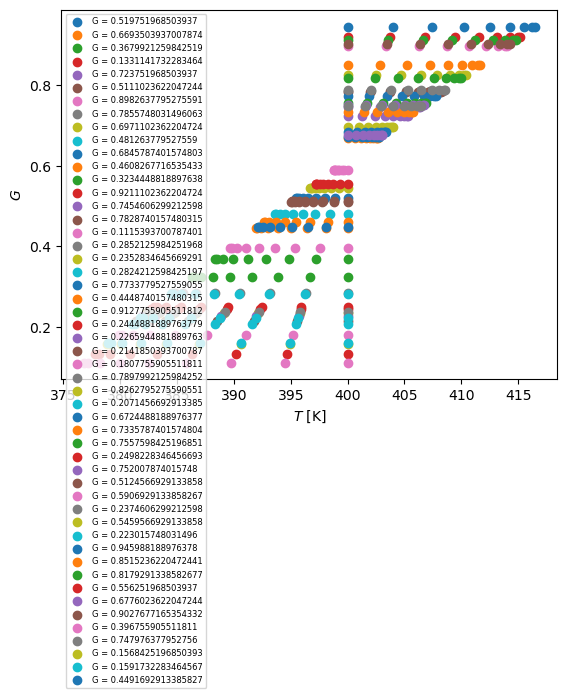

In [8]:
num_sample_plots = 50
aux_ones = np.ones((X_train.shape[1],))
samples_plotted = []

while len(samples_plotted) <= num_sample_plots:
    sample_picked = np.random.randint(0, X_train.shape[0])
    if sample_picked not in samples_plotted:
        Y_plot = Y_train[sample_picked][0] * aux_ones
        label = "G = {}".format(Y_plot[1])
        plt.scatter(X_train[sample_picked,:], Y_plot, label = label)
        samples_plotted.append(sample_picked)


plt.legend(loc = 'lower left')
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'$G$')
plt.legend(loc='best', prop={'size': 6})
plt.savefig('part1_outputs/figures/GvsT.png')
plt.show()


### Is $G(T_1, ... T_9)$ a function ? 

In [9]:
# Check if exisits different combinations of the input feature for different G values
print("The number of duplicated samples without truc operation is {}".format(Y_train.size - np.unique(Y_train).size))

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

decimals = 2
print("The number of duplicated samples with {} decimals trunc is {}".format(decimals, Y_train.size - np.unique(trunc(Y_train,decimals)).size))


The number of duplicated samples without truc operation is 0
The number of duplicated samples with 2 decimals trunc is 311


## Train the model without normalization for $X = T$ (vanish gradient effect)

In [10]:
# Paramters to select
device = 'cpu'
normalization_bool = False
plot_gif_bool = False

# range for number of data training
nun_data_training = range(10,20,10)

# model hyper-params
num_epochs = 4000
num_of_neurons = 128
num_of_hidden_layers = 5

# result arrays to be filled
testing_error = np.zeros(len(nun_data_training))
elapsed_time = np.zeros_like(testing_error)
loss = np.zeros((len(nun_data_training),num_epochs))
nets = []

for i,num_data in enumerate(nun_data_training):
    loss[i,:], testing_error[i], elapsed_time[i], net = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, X_train, Y_train, X_test, Y_test, 
        device, plot_gif_bool, normalization_bool)
    nets.append(net)
    

With num_data_training: 10 the final loss is: 1.98167e-04


## Loss vs num epochs without normalization

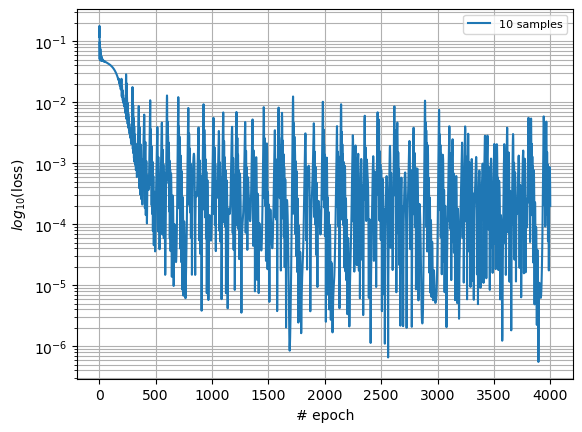

In [11]:
num_data_plot = 5
# pick unique num data point
num_data_training_rand = np.unique(np.random.choice(nun_data_training, num_data_plot))
num_data_training_rand = np.array([10])


for num_data_training_plot_case in num_data_training_rand:
    index_ndata = np.where(nun_data_training == num_data_training_plot_case)
    label = "{} samples".format(num_data_training_plot_case)     
    plt.plot(range(num_epochs), loss[index_ndata[0][0],:], label=label)

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## Compute $\theta$ as: `X_train`

In [12]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
Theta_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

   ### $G$ vs $[\theta_1, \theta_2,... \theta_9]$

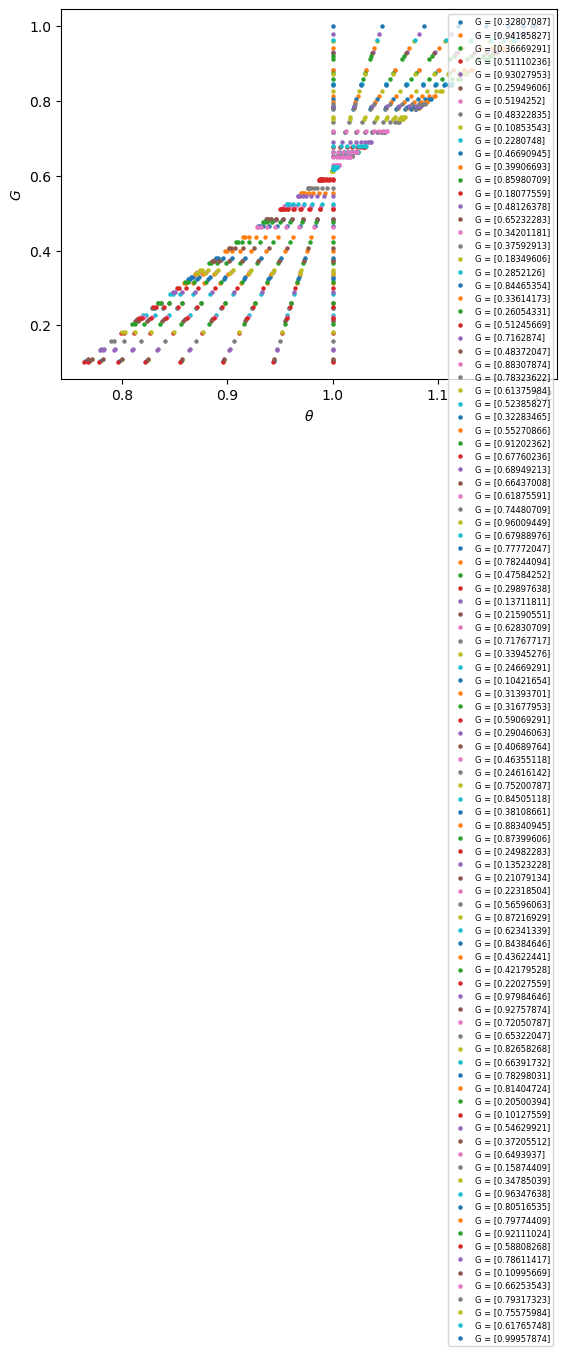

In [13]:
num_sample_plots = 100
aux_ones = np.ones((X_train.shape[1],))
samples_plotted = []

while len(samples_plotted) <= num_sample_plots:
    sample_picked = np.random.randint(0, Theta_train.shape[0])
    if sample_picked not in samples_plotted:
        G_sample = Y_train[sample_picked]
        Y_plot = G_sample * aux_ones
        label = "G = {}".format(G_sample)
        plt.scatter(Theta_train[sample_picked,:], Y_plot, label = label, s = 5)
        samples_plotted.append(sample_picked)


plt.legend(loc = 'lower left')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$G$')
plt.legend(loc='best', prop={'size': 6})
plt.savefig('part1_outputs/figures/GvsTheta.png')
plt.show()

## G vs $[\theta_1, \theta_2,... \theta_9]$ normalized and reduced

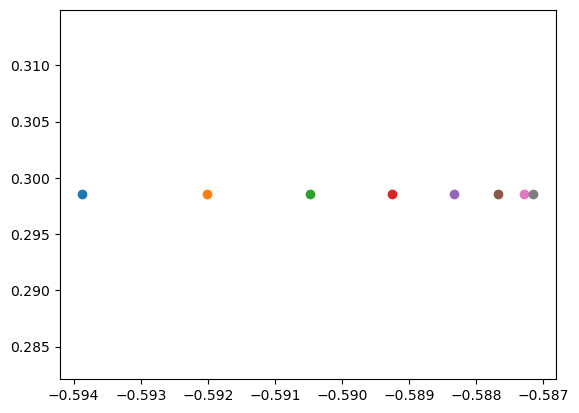

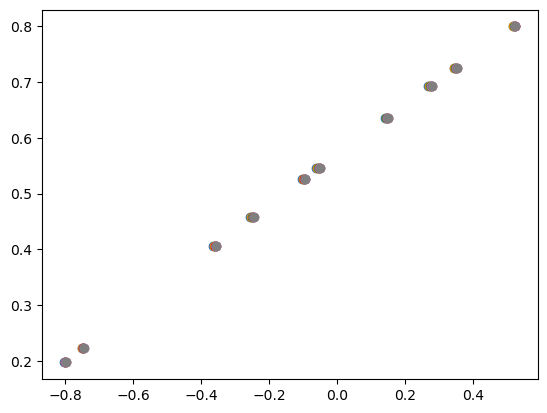

In [14]:
Theta_train_reduced = Theta_train[:,1:]
Theta_train_normalized, min_theta_reduced, max_theta_reduced = normalize(Theta_train_reduced)

num_sample_plots = 1
aux_ones = np.ones((Theta_train_normalized.shape[1],))

picked = np.random.randint(0,400,num_sample_plots)

for col in range(Theta_train_normalized.shape[1]):
    X = np.zeros((num_sample_plots,))
    Y = np.zeros((num_sample_plots,))
    for it in range(num_sample_plots):
#         print(Theta_train_normalized[picked, col] )
        X[it] = Theta_train_normalized[picked[it], col] 
        Y[it] = Y_train[picked[it]]
    plt.scatter(X,Y, label = "")
plt.show()
  
num_sample_plots = 10
aux_ones = np.ones((Theta_train_normalized.shape[1],))

picked = np.random.randint(0,400,num_sample_plots)

for col in range(Theta_train_normalized.shape[1]):
    X = np.zeros((num_sample_plots,))
    Y = np.zeros((num_sample_plots,))
    for it in range(num_sample_plots):
#         print(Theta_train_normalized[picked, col] )
        X[it] = Theta_train_normalized[picked[it], col] 
        Y[it] = Y_train[picked[it]]
    plt.scatter(X,Y, label = "")
plt.show()

## Plot $\theta(x)$, max and min for different G values

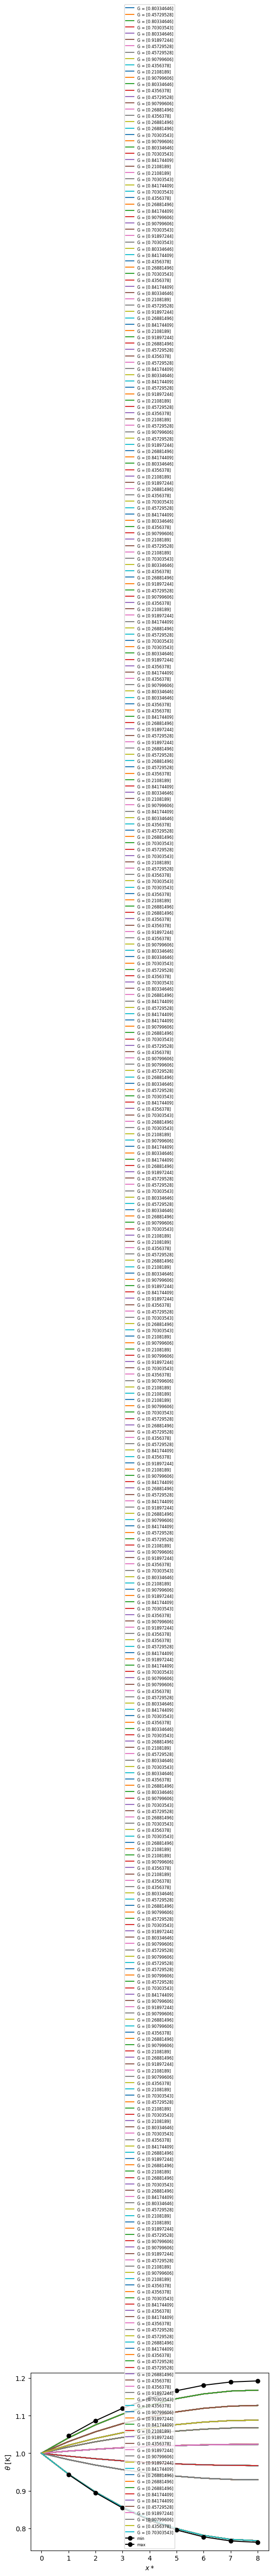

In [15]:
num_plots = 400
for i in range(num_plots):
  picked = np.random.randint(0, Theta_train.shape[1]) 
  label =  'G = {}'.format(Y_test[picked])
  plt.plot(Theta_train[picked,:],label=label)

x_reduced = range(1,9)
plt.plot(x_reduced, min_theta_reduced, 'k-o' ,label = 'min')
plt.plot(x_reduced, max_theta_reduced, 'k-o',label = 'max')

plt.ylabel(r'$\theta$ [K]')
plt.xlabel(r'$x*$')
plt.legend(loc='best', prop={'size': 6})
plt.savefig('part1_outputs/theta_vs_x.png')
plt.show()

## Train the model for different number of  $\theta$ data training

In [ ]:
# Paramters to select
normalization_bool = True
plot_gif_bool = True

# model hyper-params
num_epochs = 4000
num_of_neurons = 32
num_of_hidden_layers = 2

# range for number of data training
nun_data_training = range(10,400,10)

# result arrays to be filled
testing_error = np.zeros(len(nun_data_training))
elapsed_time_cpu = np.zeros_like(testing_error)
loss = np.zeros((len(nun_data_training),num_epochs))
nets = []

## GPU execution
device = 'cuda'
elapsed_time_gpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss[i,:], testing_error[i], elapsed_time_gpu[i], net = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, X_train, Y_train, X_test, Y_test, device)
    nets.append(net)
    
    
## CPU execution
device = 'cpu'
elapsed_time_cpu = np.zeros_like(testing_error)

print("Training with : " + device)
for i,num_data in enumerate(nun_data_training):
    loss[i,:], testing_error[i], elapsed_time_cpu[i], net = train_test_model(
        num_data, num_of_neurons, num_of_hidden_layers, num_epochs, Theta_train, Y_train, Theta_test, Y_test,
        device, plot_gif_bool, normalization_bool)
    nets.append(net)


Training with : cuda
With num_data_training: 10 the final loss is: 3.37470e-07
With num_data_training: 20 the final loss is: 6.46677e-07
With num_data_training: 30 the final loss is: 4.70949e-07
With num_data_training: 40 the final loss is: 8.20486e-07
With num_data_training: 50 the final loss is: 8.22479e-08
With num_data_training: 60 the final loss is: 2.65193e-07
With num_data_training: 70 the final loss is: 1.33225e-06
With num_data_training: 80 the final loss is: 6.53302e-07
With num_data_training: 90 the final loss is: 1.42664e-07
With num_data_training: 100 the final loss is: 2.90980e-07
With num_data_training: 110 the final loss is: 6.45856e-07
With num_data_training: 120 the final loss is: 3.36294e-07
With num_data_training: 130 the final loss is: 2.84594e-07
With num_data_training: 140 the final loss is: 5.12533e-07
With num_data_training: 150 the final loss is: 4.59956e-07
With num_data_training: 160 the final loss is: 5.19982e-07
With num_data_training: 170 the final loss i

/tmp/ipykernel_78733/913345455.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15,10))


With num_data_training: 210 the final loss is: 2.68334e-07
With num_data_training: 220 the final loss is: 1.46490e-07
With num_data_training: 230 the final loss is: 6.24507e-07
With num_data_training: 240 the final loss is: 1.72879e-06
With num_data_training: 250 the final loss is: 1.04503e-07
With num_data_training: 260 the final loss is: 7.45541e-07
With num_data_training: 270 the final loss is: 1.51643e-06
With num_data_training: 280 the final loss is: 2.33595e-07
With num_data_training: 290 the final loss is: 7.23088e-07
With num_data_training: 300 the final loss is: 9.42287e-07
With num_data_training: 310 the final loss is: 3.45080e-07
With num_data_training: 320 the final loss is: 3.08310e-07


## Loss vs num epochs normalized

In [ ]:
num_data_plot = 5
# pick unique num data point
num_data_training_rand = np.unique(np.random.choice(nun_data_training, num_data_plot))
num_data_training_rand = np.array([10, 20, 50, 150, 250, 350])

ax = plt.cla()

for num_data_training_plot_case in num_data_training_rand:
    index_ndata = np.where(nun_data_training == num_data_training_plot_case)
    label = "{} samples".format(num_data_training_plot_case)     
    plt.plot(range(num_epochs), loss[index_ndata[0][0],:], label=label)

plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
plt.ylim(1e-6, 1e0)
plt.savefig('part1_outputs/figures/loss_vs_nepoch.png')
plt.show()


## Test error vs number of data training samples

In [ ]:
plt.plot(nun_data_training, testing_error, label="Testing error")
mean_loss = [ np.mean(loss[row,-11:-1])  for row in range(loss.shape[0])] 
plt.plot(nun_data_training, mean_loss, label="Test error")
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# training samples')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/test_train_error.png')
plt.show()

## Elapsed time vs num data trainig 

In [ ]:
plt.plot(nun_data_training, elapsed_time_cpu, label = 'CPU')
plt.plot(nun_data_training, elapsed_time_gpu, label = 'GPU')
plt.legend(loc='upper right', prop={'size': 6})
plt.yscale('log')
plt.xlabel('# training samples')
plt.ylabel(r'$log_{10}$(training elapsed time [s])')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/exec_time.png')
plt.show()

## Train the model for different number of hidden layers 

In [ ]:
# range for number of data training
num_hidden_layers_range = range(2,20,4)

# selected device
device = 'cpu'

# bolean to normalize
normalize_bool = True

# boolean to generate gifs
generate_gif = True

# model hyper-params
num_data_training = 400

# result arrays to be filled
testing_error = np.zeros(len(num_hidden_layers_range))
elapsed_time = np.zeros_like(testing_error)
loss_layers = np.zeros((len(num_hidden_layers_range),num_epochs))
nets = []

for i,num_hidden_layers in enumerate(num_hidden_layers_range):
    loss_layers[i,:], testing_error[i], elapsed_time[i], net = train_test_model(
        num_data_training, num_of_neurons, num_hidden_layers, num_epochs,
        X_train, Y_train, X_test, Y_test, device, generate_gif, normalize_bool)
    nets.append(net)    

## Num of hidden layers vs errors (test, train)

In [ ]:
plt.plot(num_hidden_layers_range, testing_error, label="Testing error")
plt.xticks(num_hidden_layers_range)  # Set label locations.
mean_loss = [ np.mean(loss_layers[row,-11:-1])  for row in range(loss_layers.shape[0])] 
plt.plot(num_hidden_layers_range, mean_loss, label="Test error")
plt.legend(loc='best', prop={'size': 12})
plt.xlabel('# hidden layers')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(MSE)')
plt.grid(True, which="both", ls="-")
plt.savefig('part1_outputs/figures/hiddden_layer_analysis.png')
plt.show()